## Loading necessary libraries

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Modeling
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Warnings
import warnings
warnings.filterwarnings("ignore")


In [29]:
def plot_confusion_matrix(y_test, y_pred, target_column):
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Display class labels if you know them
    labels = df[target_column].astype('category').cat.categories.tolist()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def plot_feature_importances(model, feature_names):
    # Get feature importances
    importances = model.feature_importances_
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances, y=feature_names, palette="viridis")
    plt.title("XGBoost Feature Importances")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

def calculate_f1_score(y_true, y_pred):
    from sklearn.metrics import f1_score
    # Macro F1 Score: treats all classes equally
    f1_macro = f1_score(y_test, y_pred, average='macro')

    # Micro F1 Score: globally by counting total true positives/negatives
    f1_micro = f1_score(y_test, y_pred, average='micro')

    # Weighted F1 Score: accounts for support (number of true instances per class)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')

    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Micro): {f1_micro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")


def f1_per_class(y_test, y_pred, class_labels = None):
    # Compute F1 score per class
    class_f1_scores = f1_score(y_test, y_pred, average=None)

    # Set default class labels if not provided
    if class_labels is None:
        class_labels = sorted(set(y_test))

    # Plot
    plt.figure(figsize=(8, 5))
    sns.barplot(x=class_labels, y=class_f1_scores, palette='rocket')
    plt.title("F1 Score per Class")
    plt.xlabel("Class")
    plt.ylabel("F1 Score")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

In [3]:
# Load selected feature columns
selected_cols_df = pd.read_csv("./data/feature_columns.csv")
selected_columns = selected_cols_df["selected_columns"].tolist()
selected_columns

['high_activity',
 'packets_ratio',
 'source_port',
 'low_activity',
 'bytes_ratio',
 'destination_port',
 'nat_destination_port',
 'elapsed_time_(sec)',
 'nat_source_port',
 'burst_transfer',
 'bytes_per_sec']

In [4]:
# Load your dataset
df = pd.read_csv("./data/final_data.csv")  # Replace with actual file path
df.shape

(57170, 12)

In [5]:
df.head()

,high_activity,packets_ratio,source_port,low_activity,bytes_ratio,destination_port,nat_destination_port,elapsed_time_(sec),nat_source_port,burst_transfer,bytes_per_sec,action
0,0,0.500000,57222,0,1.119048,53,53,30,54587,0,5.900000,allow
1,0,1.000000,56258,0,0.504891,3389,3389,17,56258,0,280.470572,allow
2,0,0.500000,6881,0,0.975207,50321,50321,1199,43265,0,0.198499,allow
3,0,1.000000,50553,0,0.760847,3389,3389,17,50553,0,195.705871,allow
4,0,0.684211,50002,0,0.364781,443,443,16,45848,0,1584.874901,allow


In [6]:
feature_columns = selected_columns
target_column = 'action'

In [7]:
print(df.shape)

print(df[selected_columns + [target_column]].dropna().shape)


(57170, 12)
(57170, 12)


In [ ]:
# Encode target
df[target_column] = df[target_column].astype('category').cat.codes

In [9]:
df.rename(columns={'action' : "target"}, inplace=True)

In [10]:
df.head()

,high_activity,packets_ratio,source_port,low_activity,bytes_ratio,destination_port,nat_destination_port,elapsed_time_(sec),nat_source_port,burst_transfer,bytes_per_sec,target
0,0,0.500000,57222,0,1.119048,53,53,30,54587,0,5.900000,0
1,0,1.000000,56258,0,0.504891,3389,3389,17,56258,0,280.470572,0
2,0,0.500000,6881,0,0.975207,50321,50321,1199,43265,0,0.198499,0
3,0,1.000000,50553,0,0.760847,3389,3389,17,50553,0,195.705871,0
4,0,0.684211,50002,0,0.364781,443,443,16,45848,0,1584.874901,0


In [11]:
df.target.value_counts()

target
0    37439
2    11635
1     8042
3       54
Name: count, dtype: int64

In [12]:
target_column = 'target'

## Splitting the dataset

## **using use stratified sampling**

In [13]:
# split X and y
X = df[feature_columns]
y = df[target_column]

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (57170, 11), y shape: (57170,)


In [14]:
## splitting the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (45736, 11), y_train shape: (45736,)
X_test shape: (11434, 11), y_test shape: (11434,)


In [15]:
y_train.value_counts()

target
0    29951
2     9308
1     6434
3       43
Name: count, dtype: int64

In [16]:
y_test.value_counts()

target
0    7488
2    2327
1    1608
3      11
Name: count, dtype: int64

### Model development

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score


In [18]:
# Number of unique classes
num_classes = len(np.unique(y))
num_classes

4

In [19]:
## Create a pipeline with XGBClassifier
pipeline = Pipeline([
    # ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        objective='multi:softprob',
        num_class=num_classes,
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42,
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1
    ))
])




In [20]:
# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None, num_class=4, ...))])

In [23]:
## Make predictions
y_pred = pipeline.predict(X_test)

In [24]:
print("📊 Multiclass XGBoost Classifier Report:")
print(classification_report(y_test, y_pred))

print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))


📊 Multiclass XGBoost Classifier Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7488
           1       1.00      1.00      1.00      1608
           2       1.00      1.00      1.00      2327
           3       1.00      0.27      0.43        11

    accuracy                           1.00     11434
   macro avg       1.00      0.82      0.86     11434
weighted avg       1.00      1.00      1.00     11434

F1 Score (macro): 0.8555438053422814


In [25]:
target = 'target'

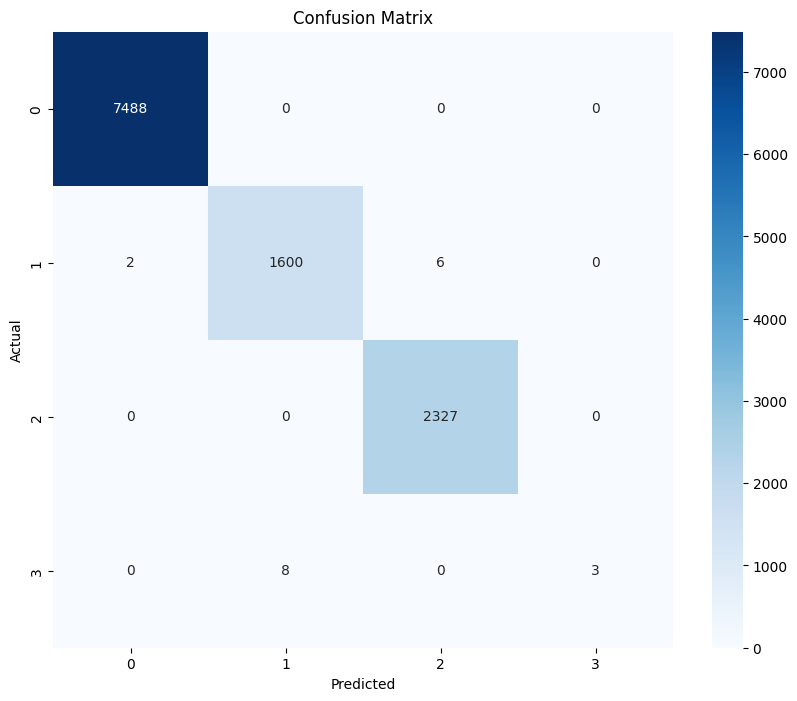

In [26]:
plot_confusion_matrix(y_test, y_pred, target_column)

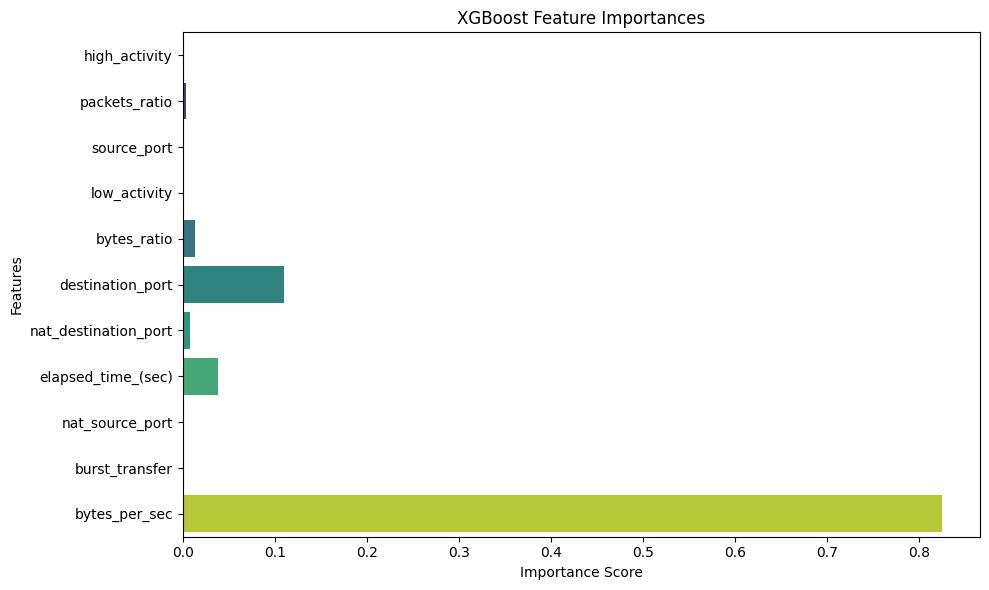

In [27]:
plot_feature_importances(pipeline.named_steps['xgb'], X.columns)

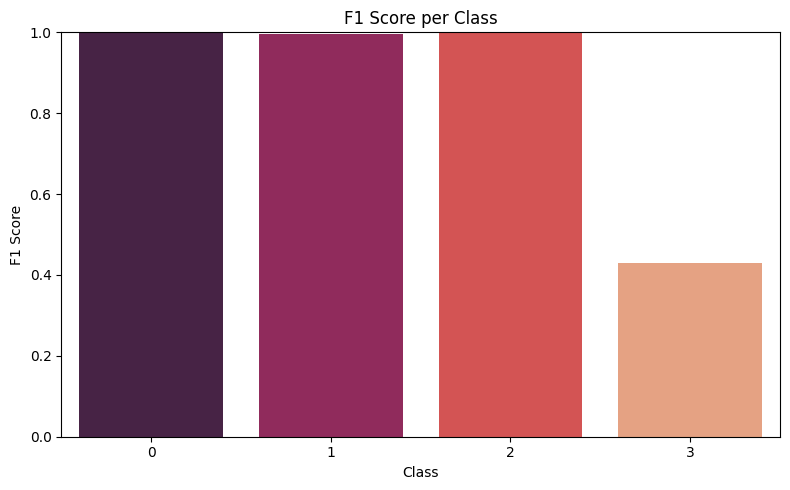

In [30]:
f1_per_class(y_test, y_pred)

**The base model performs badly in the minority class, which is expected due to the class imbalance. To address this, we can use class weights to give more importance to the minority class during training.**

## using Class Weights in XGBoost 

In [31]:
# split X and y
X = df[feature_columns]
y = df[target_column]

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (57170, 11), y shape: (57170,)


In [32]:
## splitting the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (45736, 11), y_train shape: (45736,)
X_test shape: (11434, 11), y_test shape: (11434,)


In [33]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: 0.3817568695536042, 1: 1.777121541809139, 2: 1.2284056725397507, 3: 265.90697674418607}


In [34]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight

from xgboost import XGBClassifier

In [35]:
class_weights

array([  0.38175687,   1.77712154,   1.22840567, 265.90697674])

In [36]:
# Pipeline
numeric_features = feature_columns
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
sample_weights = y_train.map(class_weight_dict)

pipeline = Pipeline(steps=[
    ("classifier", XGBClassifier(
        objective='multi:softprob',
        num_class=len(classes),
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42,
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1
    ))
])

# Fit model with sample weights
pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weights)

# Predict and evaluate
y_pred = pipeline.predict(X_test)


In [37]:

print("📊 Multiclass XGBoost Classifier Report:")
print(classification_report(y_test, y_pred))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

📊 Multiclass XGBoost Classifier Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7488
           1       1.00      1.00      1.00      1608
           2       1.00      1.00      1.00      2327
           3       1.00      0.64      0.78        11

    accuracy                           1.00     11434
   macro avg       1.00      0.91      0.94     11434
weighted avg       1.00      1.00      1.00     11434

F1 Score (macro): 0.943155176229056


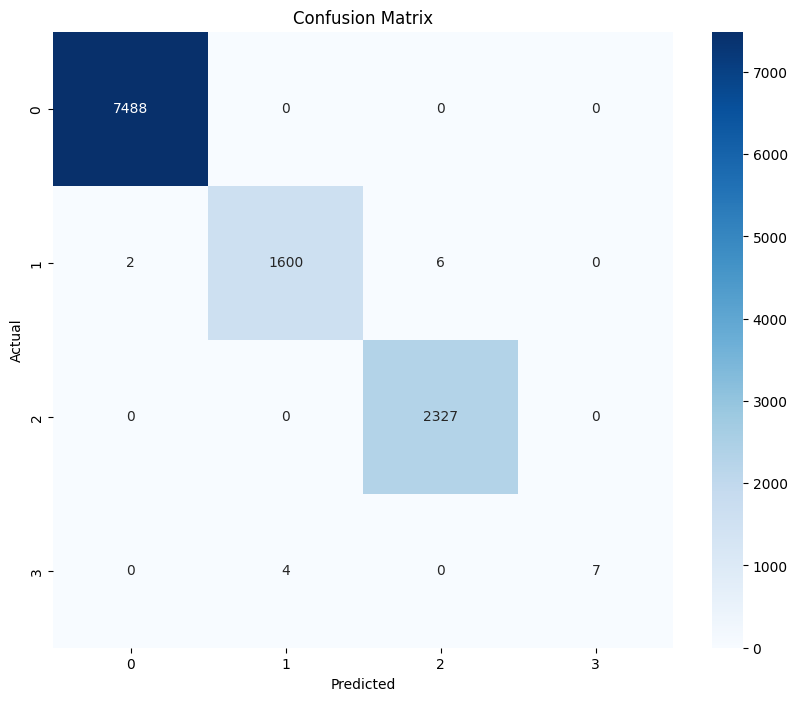

In [38]:
plot_confusion_matrix(y_test, y_pred, target_column)

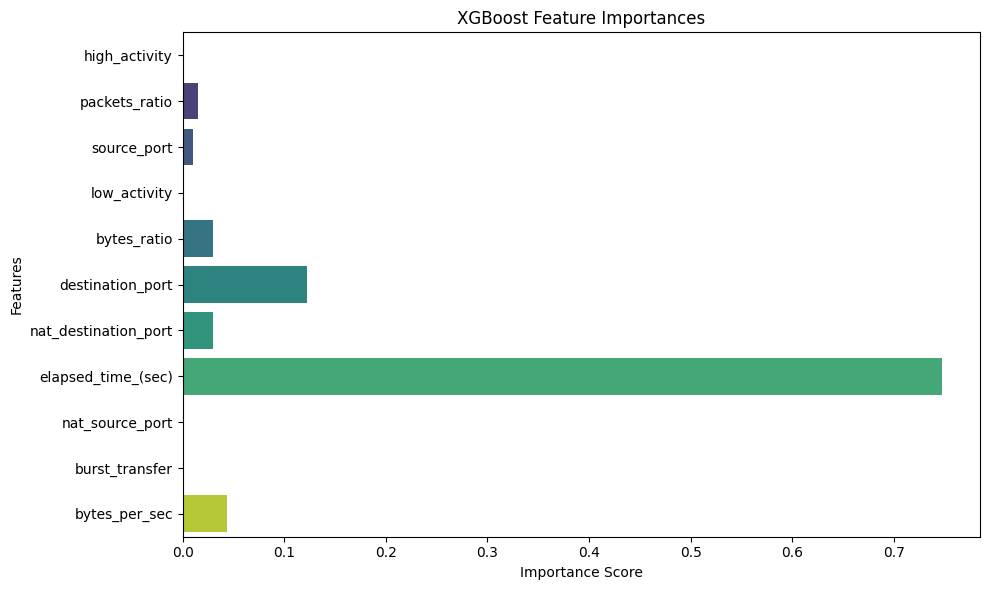

In [39]:
plot_feature_importances(pipeline.named_steps['classifier'], X.columns)

In [40]:
calculate_f1_score(y_test, y_pred)

F1 Score (Macro): 0.9432
F1 Score (Micro): 0.9990
F1 Score (Weighted): 0.9989


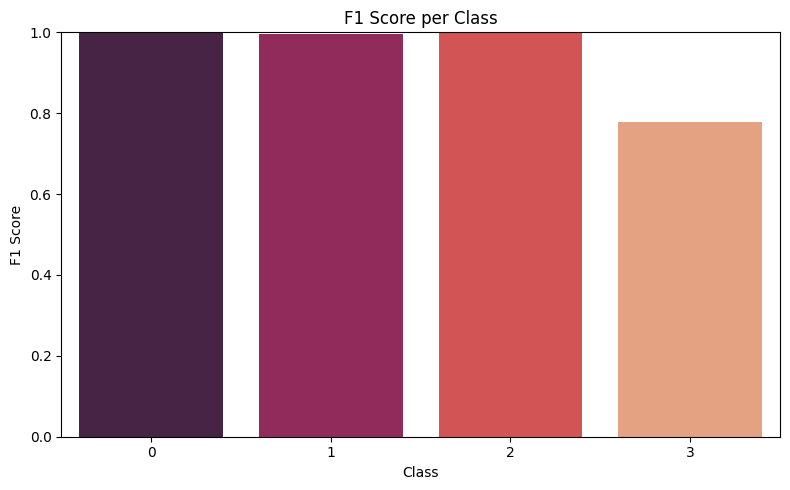

In [41]:
f1_per_class(y_test, y_pred)

## SMOTE for class imbalance

In [42]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
# !pip install --upgrade --force-reinstall scikit-learn imbalanced-learn


In [44]:
# split X and y
X = df[feature_columns]
y = df[target_column]

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (57170, 11), y shape: (57170,)


### using SMOTE to handle class imbalance

In [45]:

# Split your data (already stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Create pipeline with SMOTE and XGBoost
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42, sampling_strategy='auto')),
    ('xgb', XGBClassifier(
        objective='multi:softmax',
        num_class=len(y.unique()),
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42
    ))
])


In [ ]:
# Train
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)


In [48]:

# Evaluation
print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred))
print(f"F1 Score (Macro): {f1_score(y_test, y_pred, average='macro'):.4f}")


📊 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7488
           1       1.00      0.97      0.98      1608
           2       1.00      1.00      1.00      2327
           3       0.13      0.64      0.21        11

    accuracy                           0.99     11434
   macro avg       0.78      0.90      0.80     11434
weighted avg       1.00      0.99      1.00     11434

F1 Score (Macro): 0.7980


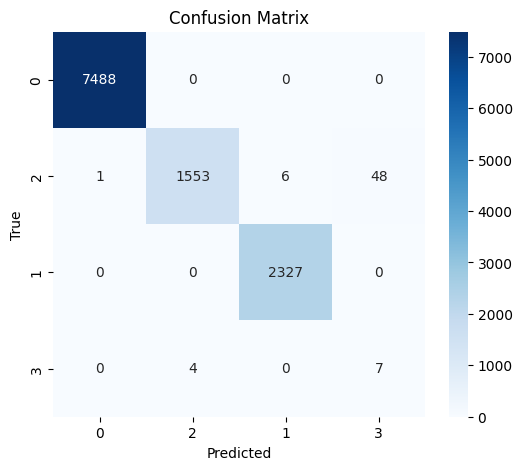

In [49]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


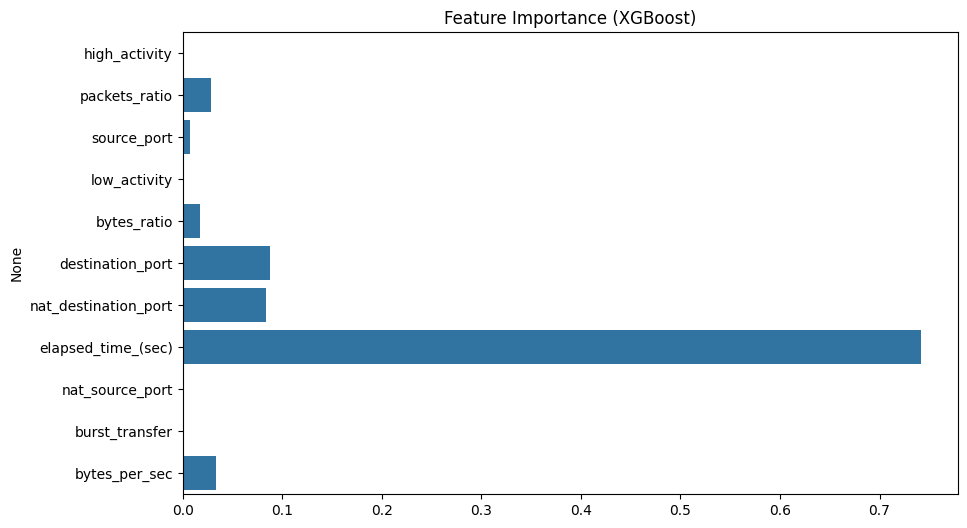

In [50]:
# Get trained XGBoost model from pipeline
xgb_model = pipeline.named_steps['xgb']

plt.figure(figsize=(10, 6))
importance = xgb_model.feature_importances_
sns.barplot(x=importance, y=X.columns)
plt.title("Feature Importance (XGBoost)")
plt.show()


### Using SOMTEENN for better handling of imbalanced data

In [51]:
from imblearn.combine import SMOTEENN

In [52]:

# Split your data (already stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Create pipeline with SMOTE and XGBoost
pipeline = Pipeline([
    ('smote', SMOTEENN(random_state=42, sampling_strategy='auto')),
    ('xgb', XGBClassifier(
        objective='multi:softmax',
        num_class=len(y.unique()),
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42
    ))
])



In [53]:
# Train
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)


In [54]:

# Evaluation
print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred))
print(f"F1 Score (Macro): {f1_score(y_test, y_pred, average='macro'):.4f}")


📊 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7488
           1       1.00      0.97      0.98      1608
           2       1.00      1.00      1.00      2327
           3       0.12      0.55      0.20        11

    accuracy                           0.99     11434
   macro avg       0.78      0.88      0.79     11434
weighted avg       1.00      0.99      1.00     11434

F1 Score (Macro): 0.7941


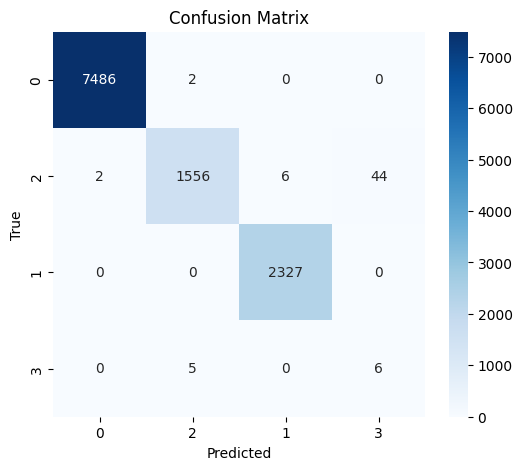

In [55]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


## using class weights works better than other techniqes